# Image colorization using CNN with a special loss


## Libraries and hardware setup


In [ ]:
!pip install kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pickle
import kornia

from statistics import mean
from skimage.color import rgb2lab

import time

from matplotlib.colors import LogNorm

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import torch.utils.data as data_utils
from torchvision.transforms import v2

In [ ]:
torch.cuda.is_available()

False

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda") #to use gpu

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import and preprocess dataset (CIFAR10)
In this section, we import the dataset and process it properly. We discard the labels (we don't care about them since our goal is colorization, not classification) and set up a new dataset whose features are the L channel and whose labels are the AB channels. We then set up a Dataloader to process the data in batches.


In [ ]:
#Transform to LAB and separate the L and (a,b) channels
class RGB_to_LAB:
  def __call__(self, sample):
    # tensor = kornia.color.rgb_to_lab(sample) # 3 x 32 x 32
    tensor = rgb2lab(sample.numpy(), channel_axis=0) # 3 x 32 x 32
    tensor = torch.tensor(tensor)
    l = tensor[0, : , :]
    bw = torch.empty([3, 32, 32])
    bw[0, : , :] = l
    bw[1, : , :] = l
    bw[2, : , :] = l
    return bw, tensor[1:, :, :]

#Function to switch back to rgb
def LAB_to_RGB(l_tensor, ab_tensor):
  tensor = torch.cat([torch.unsqueeze(l_tensor,0), ab_tensor], dim = 0)
  tensor = kornia.color.lab_to_rgb(tensor)
  return tensor

transform_rgb_lab = RGB_to_LAB()
composed = transforms.Compose([transforms.ToTensor(), transform_rgb_lab])       # qui forse non serve piu la transformazione .ToTensor()
# composed = transforms.Compose([transforms.ToTensor()])

In [ ]:
#Load dataset --> set download = True if it's the first time you're opening it
dataset = CIFAR10(root = "/content/gdrive/My Drive/CIFAR10", download = True,
                  transform = composed, train = True)

Files already downloaded and verified


In [ ]:
# Loading test

# i = 15386 #show an image

# for j in (0,1,2):
#   img = LAB_to_RGB(dataset[i][0][0][j], dataset[i][0][1])

#   rgb_image = np.transpose(img, (1, 2, 0))
#   print('\n', 'Canale L:', j)
#   plt.imshow(rgb_image)
#   plt.axis('off')  # Turn off axis
#   plt.show()


In [ ]:
#Remove labels from dataset
def discard_labels(data):
  return([datum[0] for datum in data])

dataset = discard_labels(dataset)

In [ ]:
#Separate the l and ab channels and store them as tensor

# dato = (l, ab)
def select_l(data):
  return([datum[0] for datum in data])
def select_ab(data):
  return([datum[1] for datum in data])

dataset_l =  select_l(dataset)
dataset_ab = select_ab(dataset)

#Convert to tensor form --> represents the features as one tensor 4D [index, 3, 32, 32]
dataset_l  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l])
dataset_ab = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_ab])

## Distribution of (a,b)

In [ ]:
x = dataset_ab[:,0,:,:]
x = torch.squeeze(x)

[-110. -100.  -90.  -80.  -70.  -60.  -50.  -40.  -30.  -20.  -10.    0.
   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.]
50000 

51200000.0 

Diff:  -51150000.0


<ipython-input-12-cce5222512d5>:19: RuntimeWarning: divide by zero encountered in log
  hist_log = np.log((hist/np.sum(hist)))


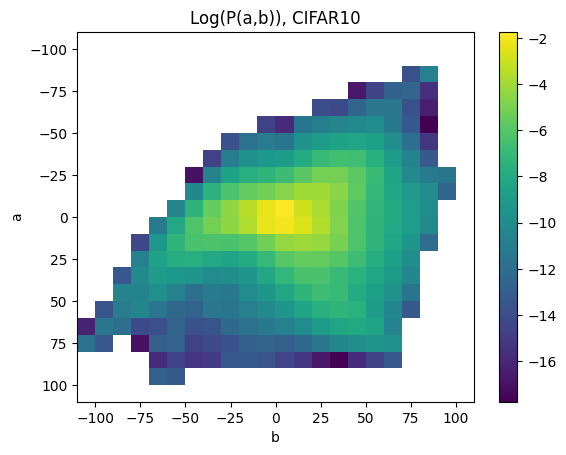

In [ ]:
a = dataset_ab[:,0,:,:].reshape(1,-1)
a = torch.squeeze(a).numpy()
b = dataset_ab[:,1,:,:].reshape(1,-1)
b = torch.squeeze(b).numpy()

x_min, x_max = -110, 110
y_min, y_max = -110, 110

hist, xedges, yedges = np.histogram2d(a, b, bins=22, range=[[x_min, x_max], [y_min, y_max]])

print(xedges)

print(len(x), '\n')
print(np.sum(hist), '\n')
print('Diff: ', len(x) - np.sum(hist))

hist_log = np.log((hist/np.sum(hist)))

plt.imshow(np.flip(hist_log, 0), interpolation='nearest', extent=[x_min, x_max, y_max, y_min], origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('b')
plt.ylabel('a')
plt.title('Log(P(a,b)), CIFAR10')
plt.show()

We now want to map each upperleft corner of a nonzero bin to its bin number

In [ ]:
Q = np.sum(np.isfinite(hist_log))
print("With our dataset we get Q = ", Q)

With our dataset we get Q =  246


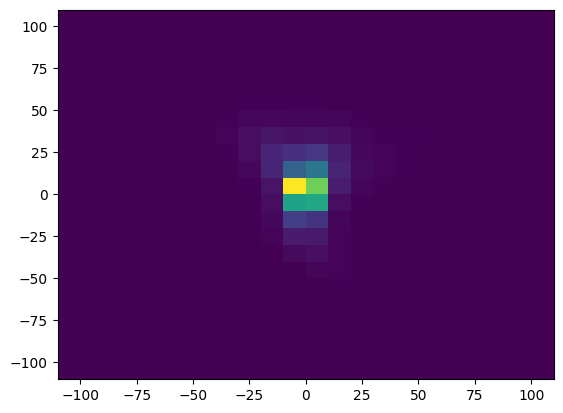

In [ ]:
hist_obj = plt.hist2d(a, b, bins = 22, range=[[x_min, x_max], [y_min, y_max]])

In [ ]:
#Keep track of where the grid points are
positions = []
indeces = []

index = 0

for i in range(len(hist_obj[1][:-1])):
  for j in range(len(hist_obj[2][:-1])):
    if hist_obj[0][i, j] > 0:
      positions.append((i,j))
      indeces.append(index)
      index += 1

dictionary = dict(zip(positions, indeces))
dictionary_inverse = dict(zip(indeces, positions)) # dictionary_inverse[132] --> (5, 7)

In [ ]:
dictionary.keys()

dict_keys([(2, 18), (2, 19), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16), (7, 17), (7, 18), (7, 19), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (8, 16), (8, 17), (8, 18), (8, 19), (8, 20), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (9, 16), (9, 17), (9, 18), (9, 19), (9, 20), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (10, 16), (10, 17), (10, 18), (10, 19), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15), (11, 16), (11, 17), (11, 18), (1

## Store new dataset in new form

In [ ]:
#Create ground truth Z_label
length = 50_000
output_tensor = torch.zeros(length, 1, 32, 32)

for image_number in range(length):
  if image_number % 1000 == 0:
    print("Image_nUmber : ", image_number)
  Z_image = np.zeros([1, 224, 224])
  image = dataset_ab[image_number, :, :, :]

  channel_a = torch.Tensor.int((image[0, : , :] + 110) // 10)
  channel_b = torch.Tensor.int((image[1, : , :] + 110) // 10)

  entries = [dictionary[index] for index in zip(torch.reshape(channel_a, [-1]).tolist(), torch.reshape(channel_b, [-1]).tolist())]
  entries = torch.reshape(torch.Tensor(entries), [1, 32, 32])

  output_tensor[image_number, :, :, :] = torch.tensor(entries)

Image_nUmber :  0


<ipython-input-18-a93353ce386e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tensor[image_number, :, :, :] = torch.tensor(entries)


Image_nUmber :  1000
Image_nUmber :  2000
Image_nUmber :  3000
Image_nUmber :  4000
Image_nUmber :  5000
Image_nUmber :  6000
Image_nUmber :  7000
Image_nUmber :  8000
Image_nUmber :  9000
Image_nUmber :  10000
Image_nUmber :  11000
Image_nUmber :  12000
Image_nUmber :  13000
Image_nUmber :  14000
Image_nUmber :  15000
Image_nUmber :  16000
Image_nUmber :  17000
Image_nUmber :  18000
Image_nUmber :  19000
Image_nUmber :  20000
Image_nUmber :  21000
Image_nUmber :  22000
Image_nUmber :  23000
Image_nUmber :  24000
Image_nUmber :  25000
Image_nUmber :  26000
Image_nUmber :  27000
Image_nUmber :  28000
Image_nUmber :  29000
Image_nUmber :  30000
Image_nUmber :  31000
Image_nUmber :  32000
Image_nUmber :  33000
Image_nUmber :  34000
Image_nUmber :  35000
Image_nUmber :  36000
Image_nUmber :  37000
Image_nUmber :  38000
Image_nUmber :  39000
Image_nUmber :  40000
Image_nUmber :  41000
Image_nUmber :  42000
Image_nUmber :  43000
Image_nUmber :  44000
Image_nUmber :  45000
Image_nUmber :  460

In [ ]:
dataset_l  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l])
dataset_Z = torch.Tensor.int(output_tensor)

#Set up new dataset
N_images = 40000
train = data_utils.TensorDataset(dataset_l[: N_images], dataset_Z[: N_images])
test = data_utils.TensorDataset(dataset_l[N_images:], dataset_Z[N_images: ])

In [ ]:
pickle.dump(train, open("df_3232.pkl", "wb"))

pickle.dump(test, open("df_3232_test.pkl", "wb"))

In [ ]:
!cp df_3232.pkl /content/gdrive/MyDrive/Vision/Progetto/FINALE_32

In [ ]:
!cp df_3232_test.pkl /content/gdrive/MyDrive/Vision/Progetto/FINALE_32

## Load new dataset

In [ ]:
objects = []
with (open("/content/gdrive/MyDrive/Vision/Progetto/FINALE_32/df_3232.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

with (open("/content/gdrive/MyDrive/Vision/Progetto/FINALE_32/df_3232_test.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break


In [ ]:
train = objects[0]
test = objects[1]

## Computation of $\vec{w}$

In [ ]:
#Store indeces as tensor

position_tensor = torch.zeros([len(hist_obj[1][:-1]), len(hist_obj[2][:-1])] )
for position, index in zip(positions, indeces):
  position_tensor[position[0], position[1]] = index

position_tensor = torch.Tensor.int(position_tensor)

In [ ]:
l = 0.5                                  # lambda
p = np.ndarray.flatten(hist_obj[0])
p = p[p > 0.]                            # p is a 1D array with the non-zero probabilities
p = p / np.sum(p)

Q = len(p)

w = 1 / ((1-l)*p + l/Q)
w = w / np.dot(w , p)

In [ ]:
#Plot w to check if it's ok
zeros = np.zeros((22, 22))
for i in range(len(w)):
  zeros[dictionary_inverse[i]] = w[i]

Text(0.5, 1.0, 'w values')

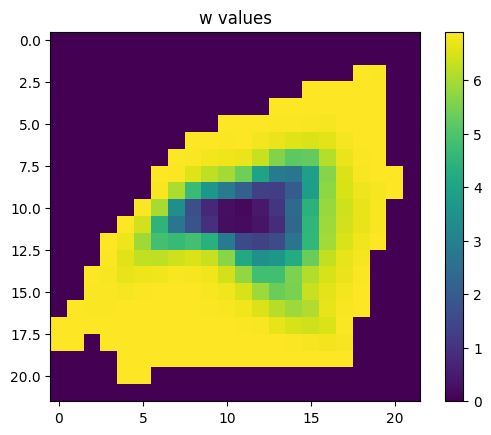

In [ ]:
im = plt.imshow(zeros)
plt.colorbar(im)
plt.title("w values")

## Training (special loss)
We train the network, using the following loss:

$L_{cl} = - \sum_{h,w, q} v(Z_{hw}) Z_{h,w,q}\log(\hat{Z}_{hwq})$,  $v(Z_{hw}) = w_{q^*}$, where $q^*$ is the index of the corresponding bin. We encode the ground truth $Z_{h,w,q}$ using one-hot-encoding.

*Reminder: Z has the shape of (1, h, w, q)*.

In [ ]:
#Data loader
batch_size = 100
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
w = torch.tensor(w)
w = w.clone().detach()

In [ ]:
class network_model_new_loss(nn.Module):
  def __init__(self):
    super(network_model_new_loss, self).__init__()

    resnet = models.resnet18(weights = "IMAGENET1K_V1")                   # import all resnet18 already trained
    self.resnet_base = nn.Sequential(*list(resnet.children())[0:6])       # take the first 6 layers of resnet, which end with 128 channels

    for param in self.resnet_base.parameters():                           # freeze the parameter of resnet_base
      param.requires_grad = False


    # define our layers on top of resnet <-- output: Qx32x32              # create my additional model to put after resnet
    self.cnn_next = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor = 2),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor = 2),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, Q, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(Q),
      nn.ReLU(),
      nn.Upsample(scale_factor = 2)
    )

  def forward(self, input):
    y = self.resnet_base(input)                                            # first go through resnet
    z = self.cnn_next(y)                                                   # then go through our layers
    return z

In [ ]:
network = network_model_new_loss()                                         # CNN
loss = nn.CrossEntropyLoss()                                               # We begin with a simple MSE loss function
optim = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma = 0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


In [ ]:
losses_train = []
losses_val = []

epochs = 100
patience = 10                                                              # how many epochs of non decreasing validation we accept
min_val = 0                                                                # minimum validation loss (initialized to a meaningless value - we will update it at the first epoch)

PATH = "/content/gdrive/MyDrive/CIFAR10/model_trained_horizontalflip.pt"

w = w.to(device)

v_prova = torch.ones([batch_size, 32, 32])


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])


with torch.autograd.set_detect_anomaly(False):
  for epoch in range(epochs):
    print("Epoch ", epoch)
    network.train()
    i = 0
    ls = []
    for features, labels in train_loader:
      transformed_batch = torch.stack([transform(img) for img in features])
      features = transformed_batch
      features = features.to(device)
      labels = labels.to(device)
      network = network.to(device)



      now = time.time()
      predictions = network(features)
      then = time.time()
      v = w[labels]

      zeros = torch.zeros(batch_size, Q, 32, 32, dtype = torch.float64).to(device)
      one_hot = zeros.scatter(dim = 1, index = labels.type(torch.int64), src = v)

      L = loss(predictions, one_hot)
      ls.append(L.item())

      optim.zero_grad()
      L.backward()
      optim.step()

      if i%50 == 0:
        print("Loss at iteration ",  i , " is ", L.item())
      i += 1
    losses_train.append(mean(ls))
    scheduler.step()

#########################################################################################

    # Validation loss
    network.eval()
    with torch.no_grad():
      val_batches = []
      for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        network = network.to(device)

        prediction_val = network(features)

        v = w[labels]
        zeros = torch.zeros(batch_size, Q, 32, 32, dtype = torch.float64).to(device)
        one_hot = zeros.scatter(dim = 1, index = labels.type(torch.int64), src = v)

        val_loss = loss(prediction_val, one_hot)
        val_batches.append(val_loss.item())
      print("At epoch ", epoch, " validation loss ", mean(val_batches))
      losses_val.append(mean(val_batches))

    # Early stopping
    if epoch == 1:
      min_val = mean(val_batches)

    if mean(val_batches) < min_val:
      min_val = mean(val_batches)
      torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': min_val,
            }, PATH)

    # Early stopping: break if no new minimum was reached in the last *patience* epochs

    if epoch >= patience:
        condition = 0
        for index in range(patience):
          if losses_val[-(index + 1)] > min_val:
            condition += 1
        if condition == patience:
          print("Early stopping!")
          break

Epoch  0
Loss at iteration  0  is  6.188243602112975
Loss at iteration  50  is  4.630490105230718
Loss at iteration  100  is  5.156200690435041
Loss at iteration  150  is  4.8059201659845305
Loss at iteration  200  is  5.311548088204993
Loss at iteration  250  is  5.243761150360619
Loss at iteration  300  is  4.48211487012544
Loss at iteration  350  is  4.317560375656935
At epoch  0  validation loss  4.603643126376623
Epoch  1
Loss at iteration  0  is  4.519420910979405
Loss at iteration  50  is  4.92541587213743
Loss at iteration  100  is  4.622053118209885
Loss at iteration  150  is  4.507443141512568
Loss at iteration  200  is  4.13617061493187
Loss at iteration  250  is  4.497930166601338
Loss at iteration  300  is  4.393036564568052
Loss at iteration  350  is  4.372303063697127
At epoch  1  validation loss  4.458401262385757
Epoch  2
Loss at iteration  0  is  4.56649710995265
Loss at iteration  50  is  4.615031942462184
Loss at iteration  100  is  4.593252361389928
Loss at iterati

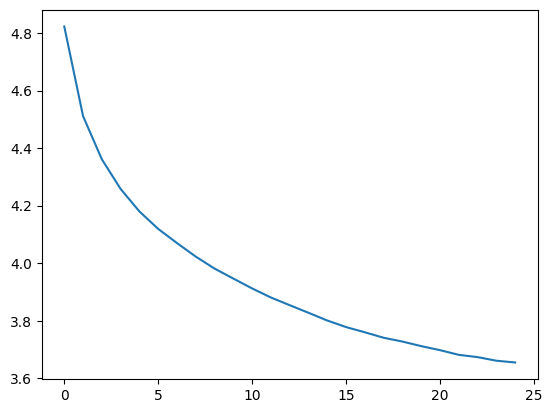

In [ ]:
plt.plot(losses_train)

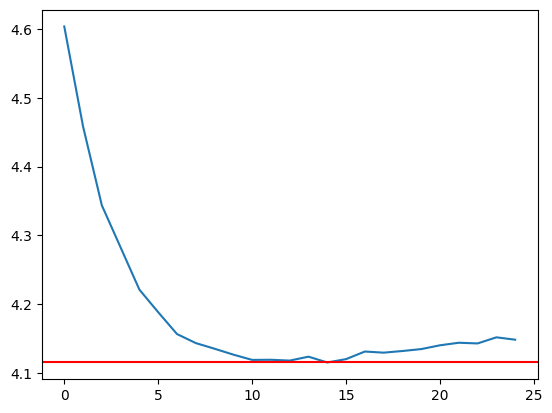

In [ ]:
plt.plot(losses_val)
plt.axhline(y=min_val, color='r', linestyle='-')

In [ ]:
min_val

4.115522734415807

## Import network with L2 loss

### Architecture


In [ ]:
class network_model_L2(nn.Module):
  def __init__(self):
    super(network_model_L2, self).__init__()

    resnet = models.resnet18(weights = "IMAGENET1K_V1")
    self.resnet_base = nn.Sequential(*list(resnet.children())[0:6]) #first 6 layers of resnet, which end with 128 channels

    for param in self.resnet_base.parameters():
      param.requires_grad = False

    # define our layers on top of resnet
    self.cnn_next = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )


  def forward(self, input):
    y = self.resnet_base(input) #first go through resnet
    z = self.cnn_next(y)        #then go through our layers
    return z

### Import weights

In [ ]:
network_L2 = network_model_L2()
data = torch.load('/content/gdrive/MyDrive/Vision/Progetto/FINALE_32/L2_3232_model_trained_horizontalflip.pt', map_location=torch.device('cpu'))

network_L2.load_state_dict(data['model_state_dict'])

network_L2.eval()

network_model_L2(
  (resnet_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Import network with new loss

In [ ]:
network_new_loss = network_model_new_loss()
data = torch.load('/content/drive/MyDrive/Vision/Progetto/FINALE_32/model_2ndloss_3232_final.pt', map_location=torch.device('cpu'))

network_new_loss.load_state_dict(data['model_state_dict'])

network_new_loss.eval()

network_model_new_loss(
  (resnet_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

## Display output

### Distance in (a, b) space

In [ ]:
a_dict = [index[0] for index in dictionary.keys()]
b_dict = [index[1] for index in dictionary.keys()]

def distance(x, y):
  return (x[0]-y[0])**2 + (x[1] - y[1])**2

def output_to_ab_annealed(output, T = .38):
  #To go back from output to ab:

  ab = torch.zeros(2, 32, 32)
  ab_indeces = torch.zeros(2, 32, 32)

  #take output, convert dimension zero to exp(log(z)/T)
  eps = 1e-7 #to avoid nan in logarithm
  output_new = output
  output_new = torch.exp(torch.log(output_new + eps) / T)
  output_new = output_new / output_new.sum(dim = 0)

  #find corresponding (i,j) using inverse dictionary
  a_entries = np.zeros([32, 32])
  b_entries = np.zeros([32, 32])

  #multiply output_new by a_dict and sum
  output_a = output_new * torch.reshape(torch.tensor(a_dict), [Q, 1, 1])
  output_b = output_new * torch.reshape(torch.tensor(b_dict), [Q, 1, 1])

  #sum along axis
  output_a = torch.sum(output_a, dim = 0)
  output_b = torch.sum(output_b, dim = 0)

  output_a = (output_a + .5)*10 - 110
  output_b = (output_b + .5)*10 - 110

  ab[0, : , : ] = torch.tensor(output_a)
  ab[1, : , : ] = torch.tensor(output_b)

  return ab

### Print output images

In [ ]:
for r in range(200):
  input_L = test[r][0]
  labels =  test[r][1]

  v = torch.tensor(w[labels])

  zeros = torch.zeros(Q, 32, 32, dtype = torch.float64)
  one_hot = zeros.scatter(dim = 0, index = labels.type(torch.int64), src = v)

  # original
  ab_truth = output_to_ab_annealed(one_hot)
  input_RGB = LAB_to_RGB(input_L[0, :, :], ab_truth)
  input_RGB.shape
  input_cpu = input_RGB.cpu()
  input_img = np.transpose(input_cpu, (1, 2, 0)).numpy()

  # reconstrcted new loss
  output = network_new_loss(torch.unsqueeze(input_L, 0))
  output = torch.squeeze(output, 0)
  output_ab = output_to_ab_annealed(output)

  output_RGB = LAB_to_RGB(input_L[0, :, :], output_ab)
  output_cpu = output_RGB.cpu()
  output_img = np.transpose(output_cpu, (1, 2, 0)).numpy()

  # reconstructed L2
  with torch.no_grad():
      predicted_ab = network_L2(torch.unsqueeze(input_L, 0))
      output_L2_img = LAB_to_RGB(input_L[0], torch.squeeze(predicted_ab, 0))
      output_L2_img = torch.permute(output_L2_img, [1,2,0])

  print('\n', '\n', '\n')

  fig, axes = plt.subplots(1, 4, figsize=(12, 4))

  axes[0].imshow(input_L[0], cmap='gray')
  axes[0].axis('off')  # Turn off axis
  axes[0].set_title('Gray scale')

  axes[1].imshow(output_L2_img)
  axes[1].axis('off')  # Turn off axis
  axes[1].set_title('Colored with L2')

  axes[2].imshow(output_img)
  axes[2].axis('off')  # Turn off axis
  axes[2].set_title('Colored with weighted loss')

  axes[3].imshow(input_img)
  axes[3].axis('off')  # Turn off axis
  axes[3].set_title('Original')

  plt.show()


Output hidden; open in https://colab.research.google.com to view.